In [226]:
import numpy as np
import  pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use("seaborn-whitegrid")
plt.rcParams["font.size"] = 14

In [227]:
# Use for all the same features
data = pd.read_csv("Cleaned_2014.csv")
data2 = pd.read_csv("Cleaned_2015.csv")
data3 = pd.read_csv("Cleaned_2016.csv")
data4 = pd.read_csv("Cleaned_2017.csv")
data5= pd.read_csv("Cleaned_2018.csv")


data_price = data.loc[:, ["2015 PRICE VAR [%]"]]
data_price2 = data2.loc[:, ["2016 PRICE VAR [%]"]]
data_price3 = data3.loc[:, ["2017 PRICE VAR [%]"]]
data_price4 = data4.loc[:, ["2018 PRICE VAR [%]"]]
data_price5 = data5.loc[:, ["2019 PRICE VAR [%]"]]

a = []
for i in list(data):
  if i in list(data2) and i in list(data3) and i in list(data4) and i in list(data5):
      a.append(i)

data = data[list(a[1:])].join(data_price)
data2 = data2[list(a[1:])].join(data_price2)
data3 = data3[list(a[1:])].join(data_price3)
data4 = data4[list(a[1:])].join(data_price4)
data5 = data5[list(a[1:])].join(data_price5)

df_list = [data, data2, data3, data4, data5]
#Concatenate all df to one to use it for the ML_tool
#df = pd.concat([data,data2,data3,data4,data5])

#df.to_csv("df.csv")
#Make a pair plot to show hot they are connected, It takes big amounts of computational power to do it for all but some can be calculated
#for i in df_list:
    #sns.pairplot(i.iloc[:,30:], hue="Class")

In [228]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, neighbors
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA

data = data.drop(["Sector"], axis=1)
x_data = data.drop(["Class"],axis=1)
y_data = data["Class"]
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(x_data)
data = pd.DataFrame(X_data_minmax,columns=list(x_data))

X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2, random_state = 1)
#We could choose with neighbors.KNeighborsClassifier(n_neighbors=#) the amount of neighbors but it decides to choose the best one by itself, if we try to add a number it is always worse than the default
#knn_clf=KNeighborsClassifier() #by using KNN we get a score of 0.65, but using SVC we have 0.85 a huge improvement


Confusion Matrix:
[[188   5 221]
 [  6  27   6]
 [ 35  12 257]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.45      0.58       414
           1       0.61      0.69      0.65        39
           2       0.53      0.85      0.65       304

    accuracy                           0.62       757
   macro avg       0.66      0.66      0.63       757
weighted avg       0.69      0.62      0.62       757

Accuracy: 0.6235138705416117
Confusion Matrix:
[[334  13  67]
 [ 23   3  13]
 [132  12 160]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       414
           1       0.11      0.08      0.09        39
           2       0.67      0.53      0.59       304

    accuracy                           0.66       757
   macro avg       0.49      0.47      0.47       757
weighted avg       0.65      0.66      0.65       757

Accuracy: 0.6565389696169088
Confus

/Users/josip/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josip/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/josip/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[402   5   7]
 [ 25   1  13]
 [ 27   5 272]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       414
           1       0.09      0.03      0.04        39
           2       0.93      0.89      0.91       304

    accuracy                           0.89       757
   macro avg       0.64      0.63      0.63       757
weighted avg       0.86      0.89      0.88       757

Accuracy: 0.8916776750330251


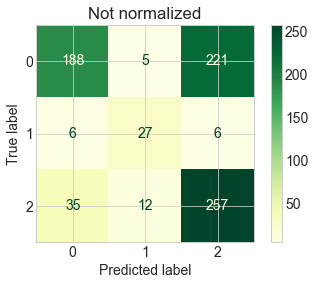

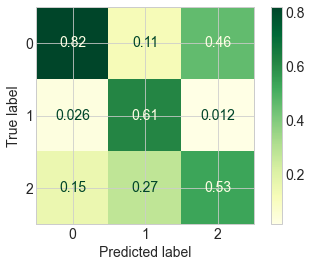

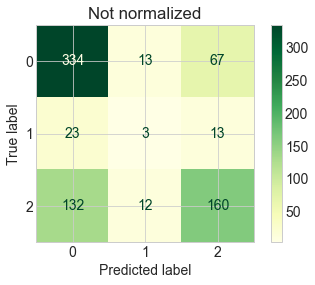

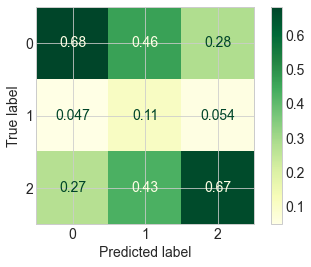

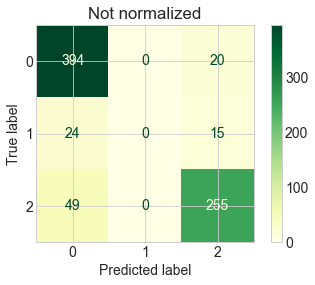

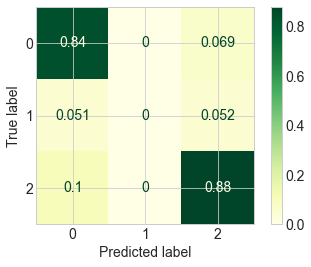

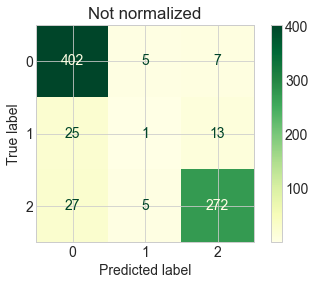

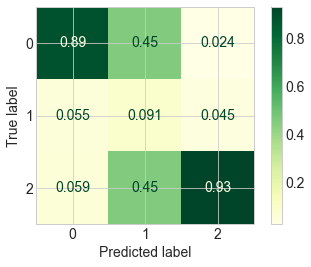

In [232]:

knn=KNeighborsClassifier()
svc=SVC(random_state=0)
lda = LDA(solver="lsqr")
qda = QDA()
options= [qda, knn, svc, lda]
for i in options:
    i.fit(X_train,y_train)
    ypred=i.predict(X_test)
    result = confusion_matrix(y_test, ypred)
    print("Confusion Matrix:")
    print(result)
    result1 = classification_report(y_test, ypred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,ypred)
    print("Accuracy:",result2)

    disp = ConfusionMatrixDisplay(confusion_matrix=result,
                                  display_labels=i.classes_)
    disp.plot(cmap="YlGn")
    disp.ax_.set_title("Not normalized")

    plot_confusion_matrix(i, X_test, y_test, cmap="YlGn", normalize="pred")

In [230]:
"""plt.scatter(data[price], data.Revenue, marker=".", label="Sample")
plt.plot(data[price], reg.fittedvalues, c="k", label="Fit")
plt.ylabel("Revenue")
plt.xlabel("Price in %")
plt.legend()"""

'plt.scatter(data[price], data.Revenue, marker=".", label="Sample")\nplt.plot(data[price], reg.fittedvalues, c="k", label="Fit")\nplt.ylabel("Revenue")\nplt.xlabel("Price in %")\nplt.legend()'

In [231]:
#https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
